<a href="https://colab.research.google.com/github/furio1999/Computer-Vision/blob/main/GAN_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Imports

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator

print("Tensorflow version %s" %tf.__version__)
print("Kerassds version %s" %keras.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.6.0
Kerassds version 2.6.0
Found GPU at: /device:GPU:0


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam

import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

import PIL
from PIL import Image
import glob

import os
import pandas as pd

from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, AveragePooling2D

from keras import regularizers
from keras import optimizers

#used in evaluation
import seaborn as sn
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
SEED=0
tf.random.set_seed(SEED)

#Preparing dataset

Downloading and unzipping Dataset

In [ ]:
#path to drive repositoryy with all the files
repo_path="content/drive/MyDrive/homeworks_projects/Visiope/GANFingerprints"

In [ ]:
dataset_path="dataset"

train_path=f"{dataset_path}/train"
test_path=f"{dataset_path}/test"
val_path= f"{dataset_path}/val"

In [ ]:
%%capture
#download in colab
#4 gan 
zip_dataset="dataset.zip"
#4 gan + real
#zip_dataset="dataset5.zip"

#6 progan
#zip_dataset="PROGAN_dataset.zip"

%cd /
if dataset_path not in os.listdir("content"):
  zip_path=os.path.join(repo_path,zip_dataset)
  !unzip {zip_path} -d content/

Using large dataset

In [ ]:
%%capture
USING_LARGE_DATASET=False
if USING_LARGE_DATASET:
  %cd /
  !rm -r content/dataset/train
  #%cd {repo_path}
  #%cd celeb
  zip_dirs_path=os.path.join(repo_path,"celeb","zip_train_dataset")
  for f in os.listdir(zip_dirs_path):
    print(f)
    zip_path=os.path.join(zip_dirs_path,f)
    !unzip {zip_path} -d content/dataset/train/
    print("done: ",f)


In [ ]:
%cd /content
%ls

/content
dataset/  drive/  sample_data/


#Type Of Model

In [ ]:
#a,b,c,d
MODEL_TYPE="d"

#Creating train,val,test set and preprocessing


In [ ]:
batch_size=64
target_size=(128,128)

In [ ]:
#Check if some images are corrupted
def check_error_images():
  folder_path = 'dataset'
  extensions = []
  error_images=[]
  for sub in os.listdir(folder_path):
      sub_folder_path = os.path.join(folder_path, sub)
      print(sub_folder_path)
      for gan in os.listdir(sub_folder_path):
        print(gan)
        gan_path=os.path.join(sub_folder_path,gan)
        for filee in os.listdir(gan_path):
            file_path = os.path.join(gan_path, filee)
            #print('** Path: {}  **'.format(file_path), end="\r", flush=True)
            try:
              im = Image.open(file_path)
              #rgb_im = im.convert('RGB')
              if filee.split('.')[1] not in extensions:
                  extensions.append(filee.split('.')[1])
            except:
              os.remove(file_path)
              error_images.append(file_path)
  print(extensions)
  print(error_images)

In [ ]:
def create_dataframe(path,shuffle=True,n_samples=-1):
  images = [] 
  labels =[] 
  for sub_dir in os.listdir(path): 
    image_list=os.listdir(os.path.join(path,sub_dir)) 
    #list of all image names in the directory 
    image_list = list(map(lambda x:os.path.join(sub_dir,x),image_list)) 
    images.extend(image_list) 
    labels.extend([sub_dir]*len(image_list)) 

  df = pd.DataFrame({"Images":images,"Labels":labels})      
  df = df.sample(frac=1).reset_index(drop=True) # To shuffle the data 
  if n_samples>0: df=df.head(n_samples)
  return df

#use other parameter n_samples if you want to use less images
train_df=create_dataframe(train_path)
val_df=create_dataframe(val_path)
test_df=create_dataframe(test_path)


Preprocess function

In [ ]:
#Which preprocessing to use
blurring=False
noising=0   #[0,1]
cropping=(0.5,0.5) #(1.2,2)
brighting=(1.2,1.7) #(1.2,1.7)

In [ ]:
def noise(image,prob):
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
          rdn = random.random()
          if rdn < prob:
            image[i][j][0] = 0
            image[i][j][1] = 0
            image[i][j][2] = 0
          elif rdn > thres:
            image[i][j][0] = 255
            image[i][j][1] = 255
            image[i][j][2] = 255
    #print(output)
    return image


In [ ]:
def pyr(x):
  if MODEL_TYPE=="b":
    img = np.float32(x)
    while img.shape[0]!=8:
      img=cv2.pyrDown(img)
    x=img
    
  elif MODEL_TYPE=="c":

    img = np.float32(x)
    while img.shape[0]!=16:
      img=cv2.pyrDown(img)
    img16=img
    img8=cv2.pyrDown(img16)
    new_img16=cv2.pyrUp(img8)
    
    x=(new_img16-img16)

  #other preprocessing
  if blurring: x=cv2.blur(x,ksize=(5,5))
  if noising>0: x=noise(x,noising)
  return x

In [ ]:
target_size=(128,128)
if MODEL_TYPE=="c":
  target_size=(16,16)
elif MODEL_TYPE=="b":
  target_size=(8,8)

#TRAIN DATASET WITH AUGMENTATION
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    preprocessing_function=pyr,
    #brightness_range=brighting,
    #zoom_range=cropping,
  )

#using this to use only part of image
train_generator=train_datagen.flow_from_dataframe(
  dataframe=train_df,
  directory=train_path,
  x_col="Images",
  y_col="Labels",
  batch_size=batch_size,
  seed=SEED,
  shuffle=True,
  class_mode="categorical",
  target_size=target_size,
)
#VAL SPLIT WITHOUT AUGMENTATION
val_datagen = ImageDataGenerator(
  rescale = 1. / 255, 
  preprocessing_function=pyr)

val_generator=val_datagen.flow_from_dataframe(
  dataframe=val_df,
  directory=val_path,
  x_col="Images",
  y_col="Labels",
  batch_size=batch_size,
  seed=SEED,
  shuffle=True,
  class_mode="categorical",
  target_size=target_size,
)
#TEST DATASET
test_datagen = ImageDataGenerator(
    rescale = 1. / 255,preprocessing_function=pyr
  )

test_generator=test_datagen.flow_from_dataframe(
  dataframe=test_df,
  directory=test_path,
  x_col="Images",
  y_col="Labels",
  batch_size=batch_size,
  seed=SEED,
  shuffle=False,
  class_mode="categorical",
  target_size=target_size,
)

num_samples = train_generator.n
print(train_generator.class_indices)
num_classes = len(train_generator.class_indices)
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]
print(f"classes: {classnames}\t ")

Found 20000 validated image filenames belonging to 4 classes.
Found 4000 validated image filenames belonging to 4 classes.
Found 4000 validated image filenames belonging to 4 classes.
{'CramerGAN': 0, 'MMDGAN': 1, 'PROGAN': 2, 'SNGAN': 3}
classes: ['CramerGAN', 'MMDGAN', 'PROGAN', 'SNGAN']	 


Show some images

SNGAN


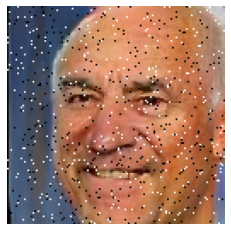

SNGAN


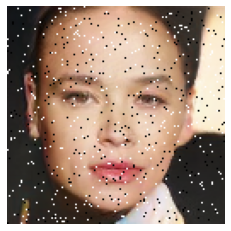

MMDGAN


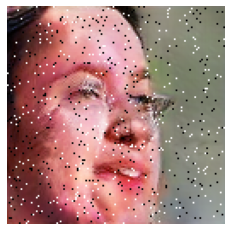

SNGAN


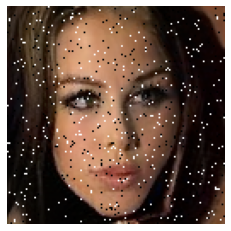

In [ ]:
n = 4
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    

#Define models

Mode 1: dimension reduced using higher strides on convolutional layers


Mode 2: dimension reduced using average pooling

###Model A

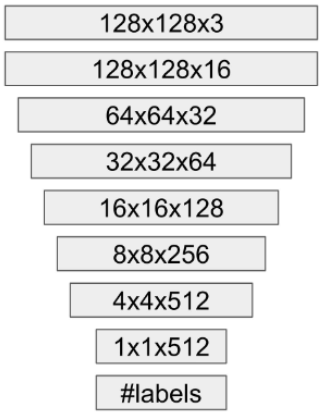

In [ ]:

def create_modelA(input_shape, num_classes, lr=0.0001,mode=1):
  if mode==1: 
    kernel_size=(1,1)
    strides=(2,2)
    pooling=False
  elif mode==2:
    kernel_size=(3,3)
    strides=(1,1)
    pooling=True
  
  model = Sequential()

  model.add(Conv2D(filters=16,kernel_size=kernel_size,strides=strides, padding='same',input_shape=(input_shape)))
  model.add(Activation('relu'))
  if pooling: model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  

  model.add(Conv2D(filters=32,kernel_size=kernel_size, strides=strides, padding='same'))
  model.add(Activation('relu'))
  if pooling: model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  

  model.add(Conv2D(filters=64,kernel_size=kernel_size,strides=strides, padding='same'))
  model.add(Activation('relu'))
  if pooling: model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  model.add(Dropout(0.2))
  

  model.add(Conv2D(filters=128,kernel_size=kernel_size,strides=strides, padding='same'))
  model.add(Activation('relu'))
  if pooling: model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  

  model.add(Conv2D(filters=256,kernel_size=kernel_size,strides=strides, padding='same'))
  model.add(Activation('relu'))
  if pooling: model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  
  
  model.add(Conv2D(filters=512,kernel_size=kernel_size,strides=strides, padding='same'))
  model.add(Activation('relu')) 

  model.add(Conv2D(filters=512,kernel_size=(3,3),strides=(2,2), padding='valid'))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  
  
  #32x32x
  # Output Layer
  model.add(Flatten())
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  # Compile

  optimizer = Adam(learning_rate=lr)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

### Model B

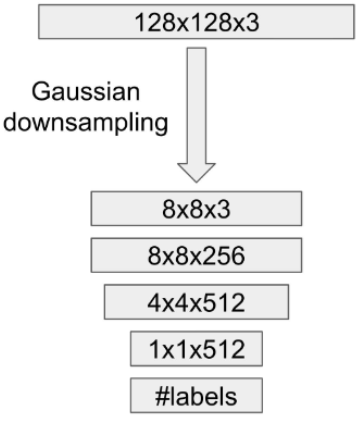

In [ ]:
def create_modelB(input_shape, num_classes, lr=0.0001,mode=1):
  if mode==1: 
    kernel_size=(1,1)
    strides=(2,2)
    pooling=False
  elif mode==2:
    kernel_size=(3,3)
    strides=(1,1)
    pooling=True
  
  model = Sequential()

  model.add(Conv2D(filters=256,kernel_size=kernel_size,strides=strides, padding='same'))
  model.add(Activation('relu'))
  if pooling: model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Conv2D(filters=512,kernel_size=kernel_size,strides=strides, kernel_regularizer=regularizers.l2(0.01), padding='same'))
  model.add(Activation('relu')) 

  model.add(Conv2D(filters=512,kernel_size=(3,3),strides=(2,2), padding='valid'))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  
  
  #32x32x
  # Output Layer
  model.add(Flatten())
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  # Compile

  optimizer = Adam(learning_rate=lr)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

###Model C

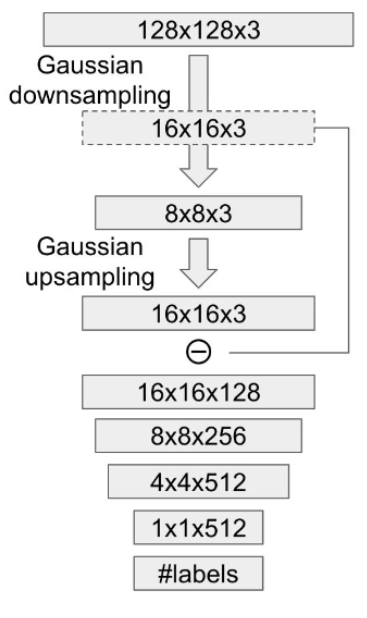

In [ ]:
def create_modelC(input_shape, num_classes, lr=0.0001,mode=1):
  if mode==1: 
    kernel_size=(1,1)
    strides=(2,2)
    pooling=False
  elif mode==2:
    kernel_size=(3,3)
    strides=(1,1)
    pooling=True

  regl2=0
  model = Sequential()

  model.add(Conv2D(filters=128,kernel_size=kernel_size,input_shape=input_shape,strides=(1,1), 
                   padding='same',kernel_regularizer=regularizers.l2(regl2)))
  model.add(Activation(tf.nn.leaky_relu))
  if pooling: model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  model.add(layers.BatchNormalization())


  model.add(Conv2D(filters=256,kernel_size=kernel_size,strides=strides, 
                   padding='same',kernel_regularizer=regularizers.l2(regl2)))
  model.add(Activation(tf.nn.leaky_relu))
  if pooling: model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  model.add(layers.BatchNormalization())
  
  
  model.add(Conv2D(filters=512,kernel_size=kernel_size,strides=strides, padding='same',
                   kernel_regularizer=regularizers.l2(regl2)))
  model.add(Activation(tf.nn.leaky_relu)) 
  model.add(layers.BatchNormalization())
  
  model.add(Conv2D(filters=512,kernel_size=(3,3),strides=(2,2), padding='valid'))
  model.add(Activation(tf.nn.leaky_relu))
  model.add(layers.BatchNormalization())
  
  #32x32x
  # Output Layer
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  # Compile

  optimizer = Adam(learning_rate=lr)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

###Model D

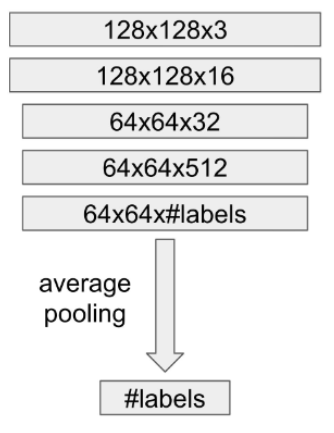

In [ ]:

def create_modelD(input_shape, num_classes, lr=0.0001,mode=1):
  if mode==1: 
    kernel_size=(1,1)
    strides=(2,2)
    pooling=False
  elif mode==2:
    kernel_size=(3,3)
    strides=(1,1)
    pooling=True

  pool_size=(64,64)

  model = Sequential()

  model.add(Conv2D(filters=16,kernel_size=kernel_size,strides=strides, padding='same',input_shape=(input_shape)))
  model.add(Activation(tf.nn.leaky_relu))
  model.add(layers.BatchNormalization())
  
  if pooling: model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  

  model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1), padding='same'))
  model.add(Activation(tf.nn.leaky_relu))
  model.add(layers.BatchNormalization())
  
  

  model.add(Conv2D(filters=512,kernel_size=(3,3),strides=(1,1), padding='same'))
  model.add(Activation(tf.nn.leaky_relu))
  model.add(layers.BatchNormalization())
  

  model.add(Conv2D(filters=num_classes,kernel_size=(3,3),strides=(1,1), padding='same'))
  model.add(Activation(tf.nn.leaky_relu))
  model.add(layers.BatchNormalization())
  
  
  model.add(AveragePooling2D(pool_size=pool_size, strides=pool_size, padding='valid'))
  
  # Output Layer
  model.add(Flatten())
  model.add(Dropout(0.3))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  # Compile

  optimizer = Adam(learning_rate=lr)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

#Train

In [ ]:
if MODEL_TYPE=="a": model=create_modelA(input_shape,num_classes,mode=2)
if MODEL_TYPE=="b": model=create_modelB(input_shape,num_classes,mode=2)
if MODEL_TYPE=="c": model=create_modelC(input_shape,num_classes,mode=2)
if MODEL_TYPE=="d": model=create_modelD(input_shape,num_classes,mode=2,lr=5e-4)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
activation_5 (Activation)    (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
average_pooling2d_2 (Average (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
activation_6 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 32)       

In [ ]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=val_generator.n//val_generator.batch_size
epochs = 30
try:
  history = model.fit(train_generator, epochs=epochs, verbose=1,\
                      batch_size=batch_size,
                      steps_per_epoch=steps_per_epoch,\
                      validation_data=val_generator)
except KeyboardInterrupt:
  pass


Epoch 1/30
312/312 [==============================] - 162s 516ms/step - loss: 1.3865 - accuracy: 0.2745 - val_loss: 1.4099 - val_accuracy: 0.2500
Epoch 2/30
312/312 [==============================] - 179s 573ms/step - loss: 1.3743 - accuracy: 0.2928 - val_loss: 1.3791 - val_accuracy: 0.2788
Epoch 3/30
312/312 [==============================] - 161s 514ms/step - loss: 1.3662 - accuracy: 0.3095 - val_loss: 1.4236 - val_accuracy: 0.2763
Epoch 4/30
312/312 [==============================] - 164s 525ms/step - loss: 1.3589 - accuracy: 0.3189 - val_loss: 1.3685 - val_accuracy: 0.2955
Epoch 5/30
312/312 [==============================] - 164s 525ms/step - loss: 1.3482 - accuracy: 0.3343 - val_loss: 1.3707 - val_accuracy: 0.3027
Epoch 6/30
312/312 [==============================] - 161s 516ms/step - loss: 1.3349 - accuracy: 0.3506 - val_loss: 1.3442 - val_accuracy: 0.3465
Epoch 7/30
312/312 [==============================] - 161s 515ms/step - loss: 1.3104 - accuracy: 0.3813 - val_loss: 1.3438 -

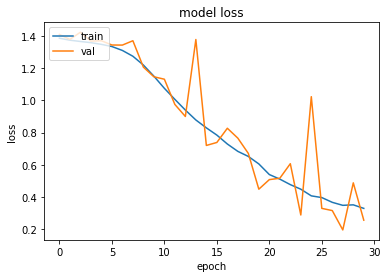

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()  

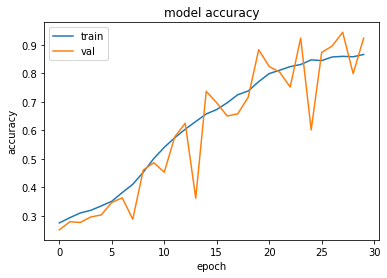

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Evaluate

In [ ]:
test_steps=test_generator.n//test_generator.batch_size

preds = model.predict(test_generator,verbose=1,steps=test_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

if len(Ypred)>len(Ytest): Ypred=Ypred[:len(Ytest)]
if len(Ytest)>len(Ypred): Ytest=Ytest[:len(Ypred)]

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))

62/62 [==============================] - 21s 338ms/step
              precision    recall  f1-score   support

   CramerGAN      0.830     0.982     0.900       993
      MMDGAN      0.958     0.911     0.934       994
      PROGAN      0.997     0.894     0.943       991
       SNGAN      0.973     0.942     0.957       990

    accuracy                          0.932      3968
   macro avg      0.939     0.932     0.933      3968
weighted avg      0.939     0.932     0.933      3968



Confusion matrix

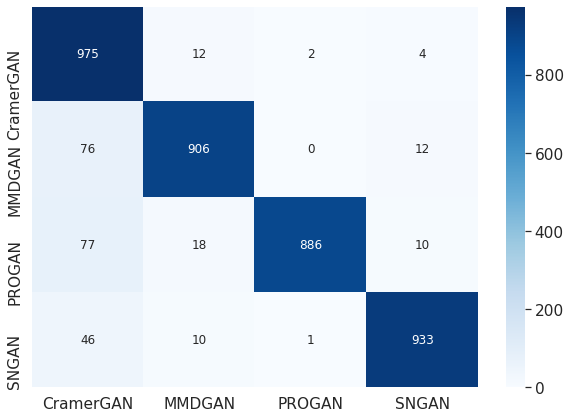

In [ ]:
cm = confusion_matrix(Ytest, Ypred)
df_cm = pd.DataFrame(cm, classnames, classnames)
df_cm
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g') # font size

plt.show()